## Smallest nonzero persistent eigenvalue of a filtration

First, create a filtration from synthetic data:

In [2]:
import gudhi as gd
import tadasets
sphere = tadasets.dsphere(n=300, d=1, r=2, noise=0.3, seed=42)
alpha = gd.AlphaComplex(points=sphere)
st = alpha.create_simplex_tree()
filtration = list(st.get_filtration())

Convert it to boundary data:

In [3]:
from persistent_laplacians.filtrations import simplices_by_dimension, compute_boundary_matrices, filtration_hash_map

unique_filtration_values = sorted(list(set([f for (_, f) in filtration])))
simplices_by_dim, simplices_by_dim_only_filt = simplices_by_dimension(filtration)
boundary_matrices = compute_boundary_matrices(simplices_by_dim)
boundary_maps_index_dict = filtration_hash_map(filtration, simplices_by_dim_only_filt)
subsampled_filtration_indices = [x for x in range(len(unique_filtration_values)) if x % 10 == 0]

## Compute the smallest persistent eigenvalue

In [9]:
from persistent_laplacians import persistent_laplacians as pl
result = pl.smallest_eigenvalue(
    boundary_matrices,
    boundary_maps_index_dict,
    subsampled_filtration_indices,
    use_scipy=False # uses PRIMME crate
)

## Plot nonpersistent eigenvalues (dim 1)

[0.0014648844270438214, 0.0014709346233519514, 0.0014942948328054066, 0.001553323359217265, 0.0015587520192277117, 0.0016825615807030821, 0.0019490993986097359, 0.0019825287541684776, 0.0019858007397914592, 0.0020365341745469602]


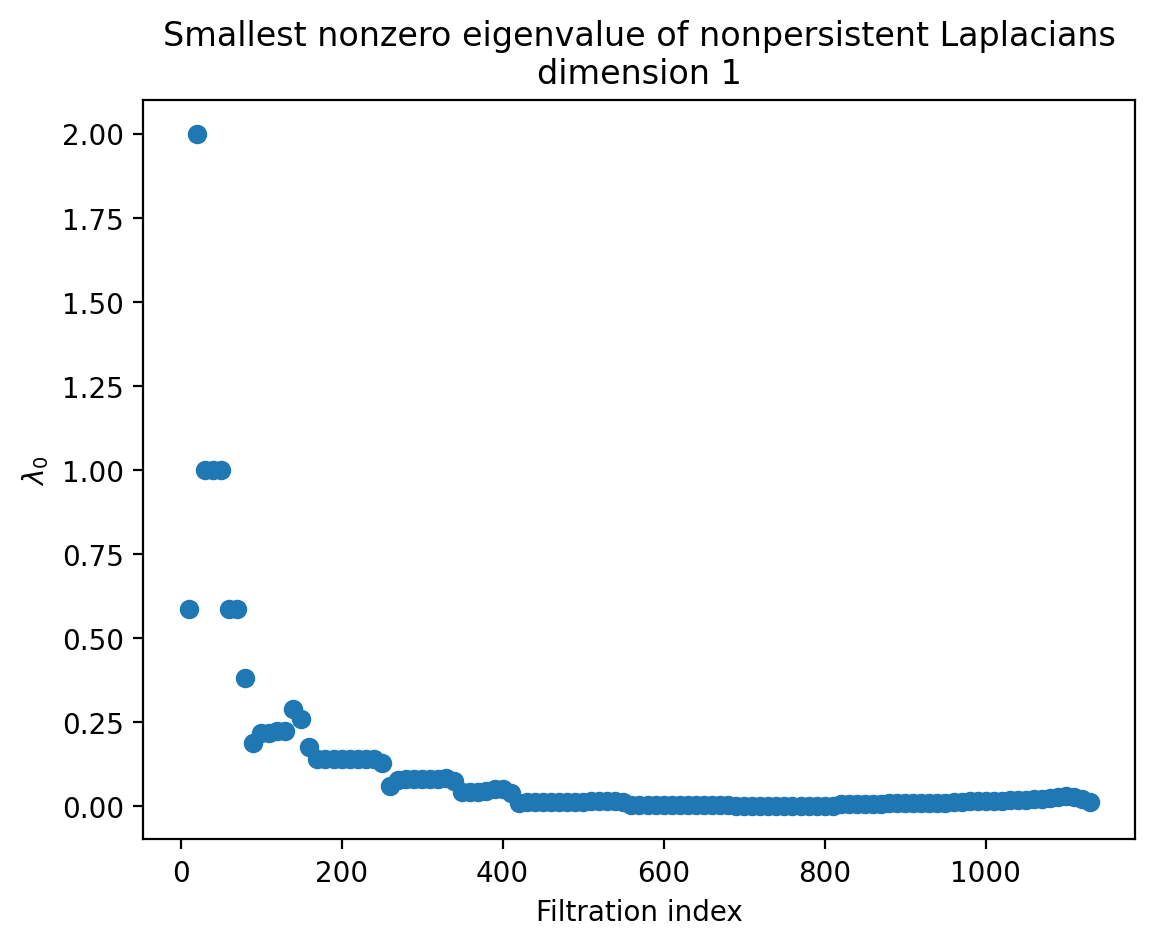

In [5]:
import matplotlib.pyplot as plt
nonpersistent = {k[0]: v[0] for (k, v) in result[1].items() if k[0] == k[1] and len(v) >= 1}
plt.figure(dpi=200)
plt.scatter(nonpersistent.keys(), nonpersistent.values())
plt.title(r"Smallest nonzero eigenvalue of nonpersistent Laplacians" + "\n" + "dimension 1")
plt.xlabel("Filtration index")
plt.ylabel(r"$\lambda_0$")

eigenvalues = sorted(nonpersistent.values())

print(eigenvalues[0:10])

## Persistent smallest nonzero eigenvalues

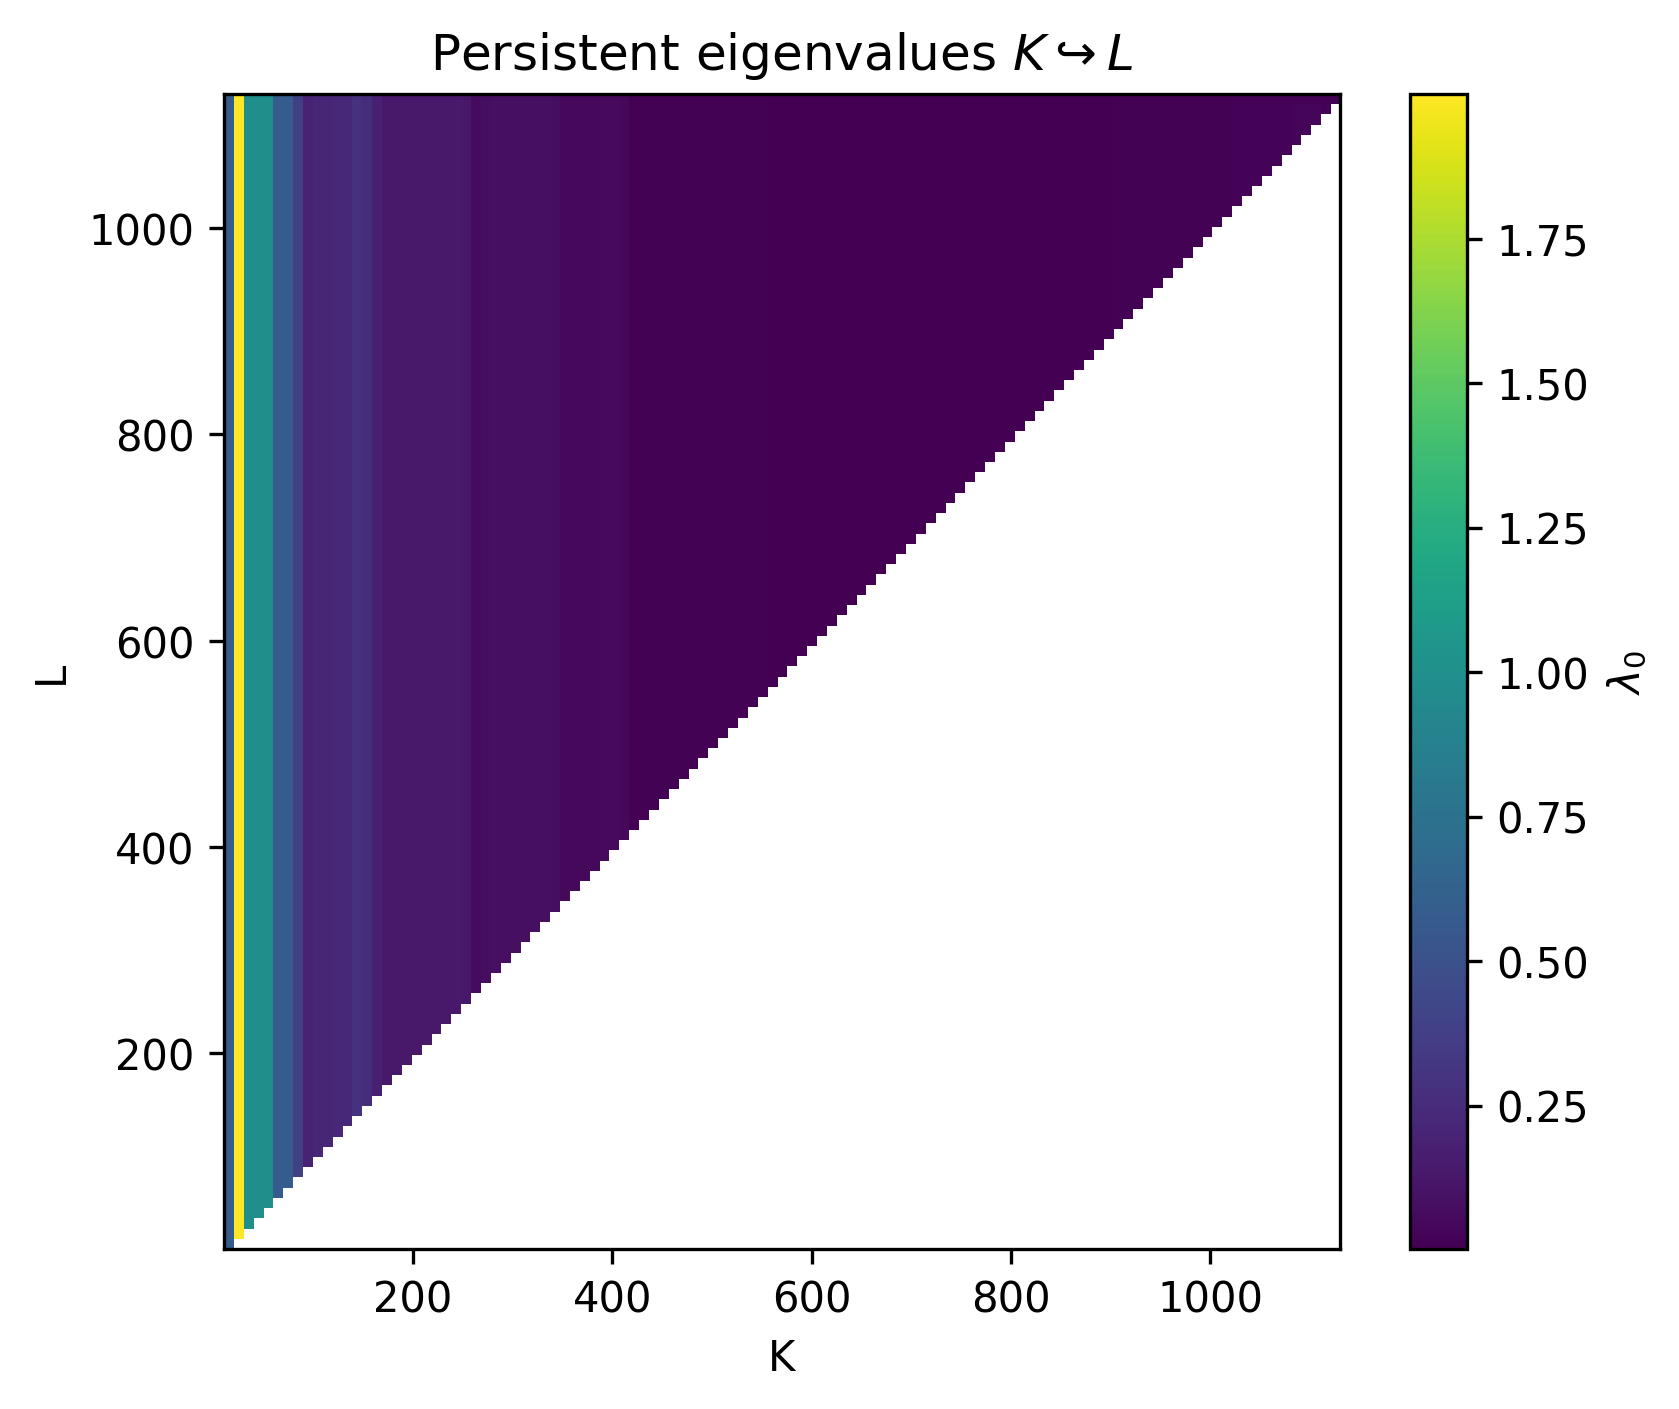

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Raw data
pts = {k: v for (k, v) in result[1].items() if len(v) >= 1}

# 1) Build sorted unique axes
xs = sorted({x for x, y in pts})
ys = sorted({y for x, y in pts})

# 2) Create matrix of NaNs
heat = np.full((len(ys), len(xs)), np.nan)

# 3) Fill matrix: row = y-index, col = x-index
x_i = {x:i for i,x in enumerate(xs)}
y_i = {y:i for i,y in enumerate(ys)}
for (x,y), v in pts.items():
    heat[y_i[y], x_i[x]] = v[0]

# 4) Plot as heatmap (no interpolation)
plt.figure(figsize=(6,5), dpi=300)
plt.imshow(
    heat,
    origin='lower',
    extent=(min(xs), max(xs), min(ys), max(ys)),
    aspect='auto'
)
plt.colorbar(label=r'$\lambda_0$')
plt.xlabel('K')
plt.ylabel('L')
plt.title(r'Persistent eigenvalues $K \hookrightarrow L$')
plt.show()

### When is the up persistent value getting used?
Whenever the diagonal eigenvalue (nonpersistent) is not the same as one of the column values, the UP persistent laplacian gets used.

In [7]:
# Find all y for which (y,y) exists
pts = result[1]
diagonal = {y: pts[(y,y)] for (y1,y2) in pts if y1==y2}
# Compare
for (x,y), v in pts.items():
    if x!=y and (x,x) in pts and (abs(v[0] - pts[(x,x)][0]) > 1e-6):
        print(f"At y={y}, x={x}: {v} ≠ diagonal {pts[(x,x)]}")

At y=1130, x=1120: [0.016450008640129056] ≠ diagonal [0.022375970943473385]
At y=1130, x=1090: [0.024807421743704407] ≠ diagonal [0.027038383217496197]
At y=1130, x=1110: [0.020073540081026468] ≠ diagonal [0.02630338783607231]
At y=1130, x=1100: [0.022071216891524283] ≠ diagonal [0.031065808220506978]


## What's the persistence barcode?

<Axes: title={'center': 'Persistence barcode'}>

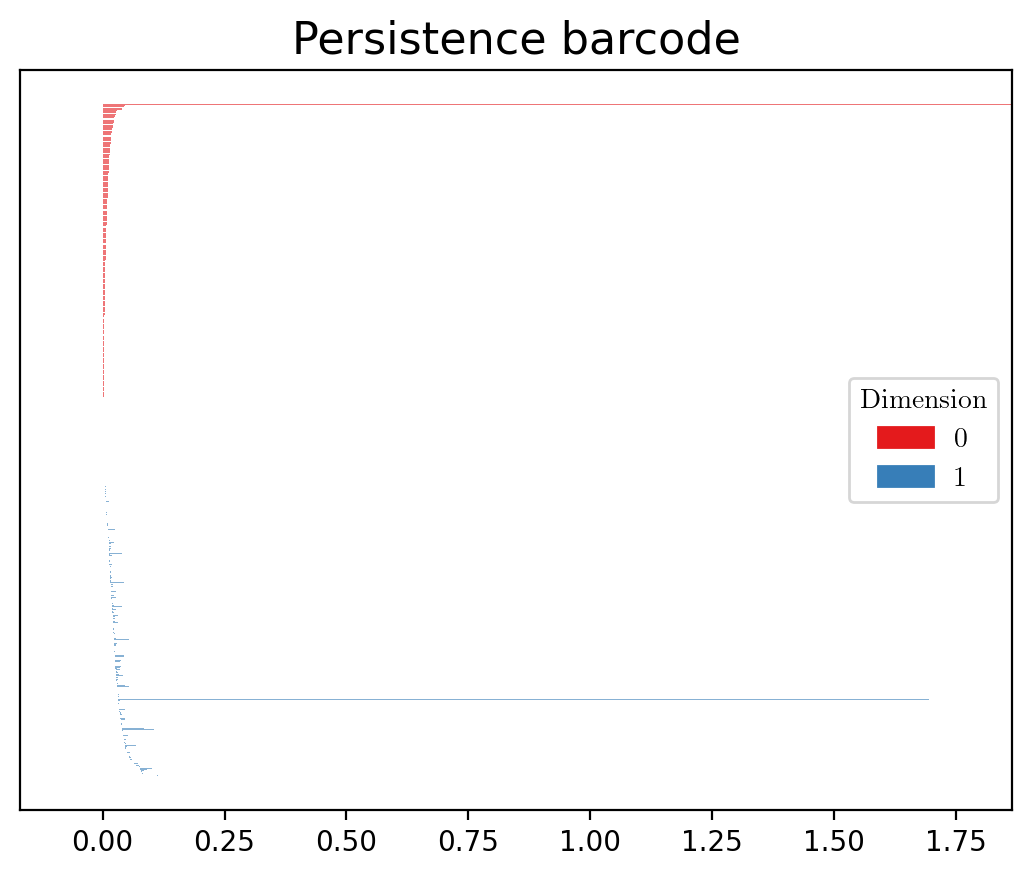

In [8]:
diag = st.persistence()
fig, ax = plt.subplots(dpi=200)
gd.plot_persistence_barcode(diag, axes=ax)